## Prediksi Penerimaan Penawaran Deposito Klien Berdasarkan Informasi Klien Bank

## 1. Perkenalan

Objective   : Melakukan prediksi apakah seorang klien akan menyetujui penawaran deposito dari bank berdasarkan dataset bank-marketing menggunakan model knn, svm, decision tree, random forest, atau adaboost. Dataset tersebut berisi informasi mengenai klien dan jawaban mereka terhadap penawaran deposito.

## 2. Import Libraries

Berikut libraries yang akan digunakan :

In [61]:
# Melakukan import libraries yang akan digunakan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from feature_engine.outliers import Winsorizer
from phik import phik_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
import pickle
import json

## 3. Data Loading

Dataset yang digunakan adalah dataset yang berisi informasi mengenai klien beserta jawaban mereka terhadap penawaran deposito

In [62]:
# Melakukan loading dataset
data = pd.read_csv('bank-full.csv', delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Berdasarkan informasi di atas, dataset mempunyai 45211 data dan 17 kolom. Selanjutnya saya akan melihat apakah dataset terdapat data duplikat atau tidak

In [64]:
# Melihat apakah dataset terdapat data duplikat atau tidak
data.duplicated().sum()

0

Berdasarkan informasi di atas, dataset tidak memiliki data duplikat. Berikutnya saya akan melihat apakah dataset terdapat missing value atau tidak

In [65]:
# Melihat apakah dataset terdapat missing value atau tidak
data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Berdasarkan informasi di atas, dataset tidak memiliki missing value. Selanjutnya saya akan membuat kolom baru bernama age group yang nantinya akan digunakan untuk eksplorasi dan analisis data dengan aturan:
- teenager: 10-19 tahun
- adult: 19-44 tahun
- pre elderly: 45-59 tahun
- elderly : 60 tahun ke atas

In [66]:
# Membuat pengelompokkan usia berdasarkan aturan yang telah dibuat
i=10
teenager = []
while i<19:
    teenager.append(i)
    i+=1
i=19
adult=[]
while i<45:
  adult.append(i)
  i+=1
i=45
pre_elderly=[]
while i<60:
  pre_elderly.append(i)
  i+=1
i=60
elderly=[]
while i<100:
    elderly.append(i)
    i+=1

# Mengelompokkan usia berdasarkan usia klien
penampung = []
for i in data['age']:
  if i in (teenager):
    penampung.append('teenager')
  elif i in (adult):
    penampung.append('adult')
  elif i in (pre_elderly):
    penampung.append('pre elderly')
  elif i in (elderly):
    penampung.append('elderly')
data['age group'] = penampung
data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age group
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,pre elderly
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,adult
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,adult
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,pre elderly
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,adult
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no,adult
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no,adult
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no,adult
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no,pre elderly
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no,adult


Berikutnya saya akan melihat apakah dataset termasuk dataset seimbang(balance) atau tidak seimbang(imbalance)

In [67]:
# Melihat apakah dataset seimbang atau tidak
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Berdasarkan informasi di atas, dataset merupakan dataset yang tidak seimbang(imbalance). Selanjutnya saya akan melakukan exploratory data analysis(eda)

## 4. Exploratory Data Analysis

Pada bagian ini akan dilakukan eksplorasi dan visualisasi data menggunakan matplotlib. Saya akan melihat persebaran kelompok usia dari klien

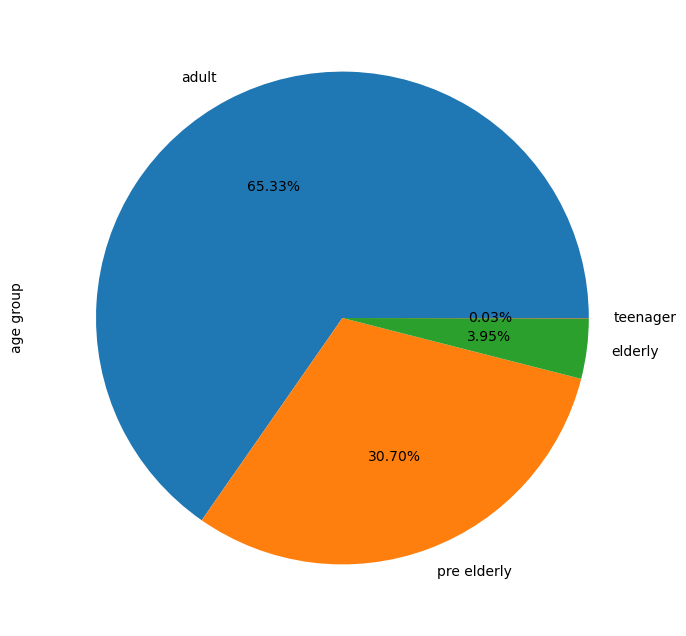

In [68]:
# Membuat pie chart dari kolom age group
fig= plt.subplots(figsize=(8,8))
data['age group'].value_counts().head().plot(kind='pie', autopct='%.2f%%')
plt.show()

Berdasarkan pie chart di atas, kelompok usia adult memiliki proporsi yang jauh lebih besar dari kelompok usia lainnya. Hal ini mungkin disebabkan karena memang sebagian besar klien di wilayah diadakan kampanye penawaran deposito merupakan kelompok usia dewasa. Selanjutnya saya akan melihat persebaran pekerjaan dari klien

<AxesSubplot:>

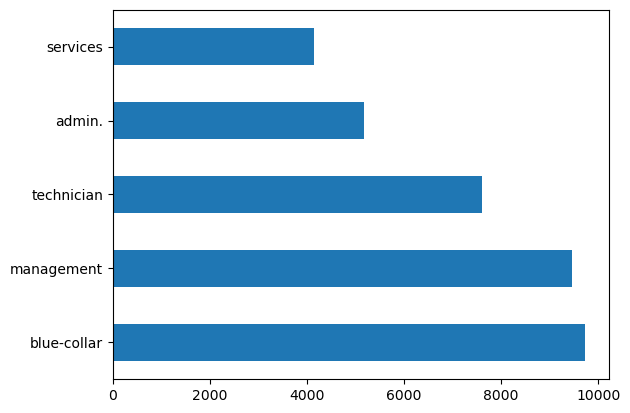

In [69]:
# Membuat bar chart dari kolom job
data['job'].value_counts().head().plot(kind='barh')

Berdasarkan pie chart di atas, pekerja kerah biru dan manajemen merupakan pekerjaan yang memegang proporsi terbanyak. Hal ini mungkin disebabkan karena kedua pekerjaan tersebut memang paling banyak di wilayah diadakan kampanye penawaran deposito. Berikutnya saya akan melihat apakah sebagian besar klien memiliki pinjaman atau tidak

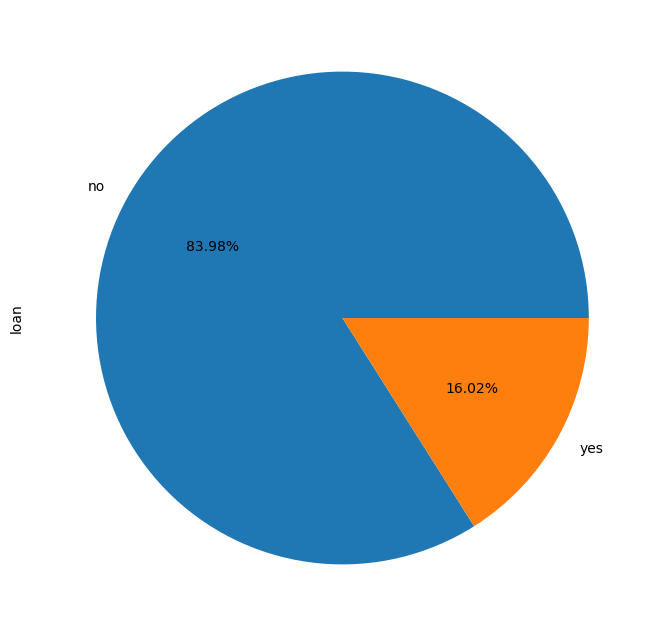

In [70]:
# Membuat pie chart dari kolom loan
fig= plt.subplots(figsize=(8,8))
data['loan'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.show()

Berdasarkan pie chart di atas, mayoritas klien tidak memiliki pinjaman. Hal ini mungkin disebabkan karena mayoritas klien mempunyai hidup yang berkecukupan atau minat terhadap pinjaman yang tidak begitu besar di wilayah diadakan kampanye penawaran deposito. Selanjutnya saya akan melihat persebaran pendidikan dari klien

<AxesSubplot:>

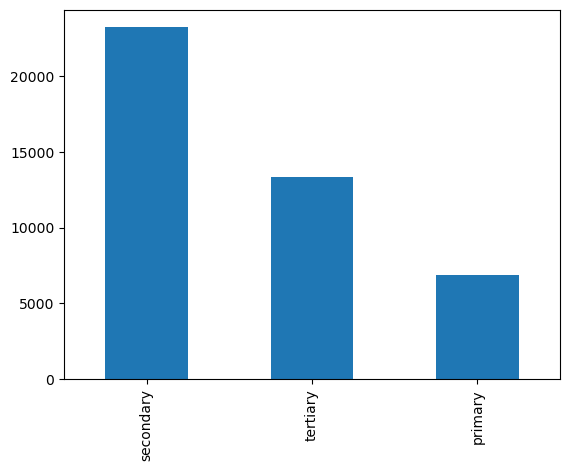

In [71]:
# Membuat bar chart dari kolom education
data['education'].value_counts().head(3).plot(kind='bar')

Berdasarkan bar chart di atas, pendidikan menengah merupakan pendidikan dengan jumlah terbanyak disusul dengan pendidikan lanjut dan terakhir pendidikan dasar. Hal ini mungkin disebabkan beberapa faktor seperti biaya melanjutkan pendidikan lanjut yang tidak murah, terbatasnya sarana pendidikan lanjut, atau minat melanjutkan pendidikan tidak begitu besar di wilayah diadakan kampanye penawaran deposito. Selanjutnya saya akan melihat apakah sebagian besar klien mempunyai pinjaman perumahan

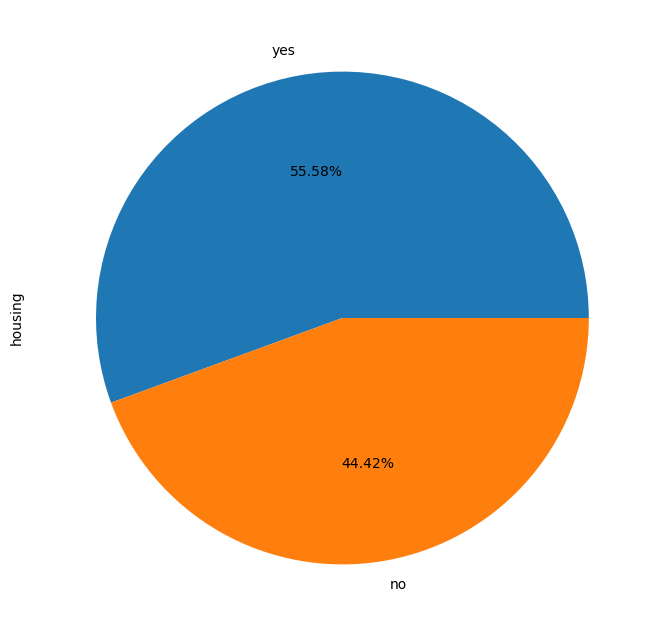

In [72]:
# Membuat pie chart dari kolom housing
fig= plt.subplots(figsize=(8,8))
data['housing'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.show()

Berdasarkan pie chart di atas, mayoritas klien memiliki pinjaman perumahan. Hal ini mungkin disebabkan oleh harga membeli rumah di di wilayah diadakan kampanye penawaran deposito cukup tinggi sehingga mayoritas memilih melakukan pinjaman perumahan. Berikutnya saya akan melakukan feature engineering

## 5. Feature Engineering

Pada bagian ini akan dilakukan persiapan data untuk model training seperti data cleaning dan data transformation. Sebelum melakukannya saya akan melakukan drop terhadap kolom duration karena menurut variable tables dari [sumber database](https://archive.ics.uci.edu/dataset/222/bank+marketing), untuk mendapatkan model prediksi yang bagus sebaiknya melakukan drop terhadap kolom tersebut. Saya juga akan melakukan drop terhadap kolom age group karena kolom tersebut hanya digunakan pada bagian eda saja

In [73]:
# Melakukan drop terhadap kolom duration dan age group
data.drop(['duration','age group'], axis=1, inplace=True)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,no


Berikutnya saya akan mengubah value(yes,no) dari y(target) menjadi angka(1,0)

In [74]:
# Mengubah value(yes,no) dari y(target) menjadi angka(1,0)
data = data.replace(['yes','no'],[1,0])
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,4,-1,0,unknown,0


### Data Inference Extraction

Pada bagian ini akan dilakukan pengambilan 1 data secara acak dari dataset yang akan dijadikan sebagai data inference

In [75]:
# Mengambil 1 data secara acak dari dataset yang akan dijadikan sebagai data inference ke dalam variabel data_inf
data_inf = data.sample(1, random_state=1)
# Menghapus data inference dari dataset
data.drop(data_inf.index, inplace=True)
# Melakukan reset index untuk data_inf dan dataset
data.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)
# Menghapus target di data_inf
data_inf.drop(['y'], axis=1, inplace=True)

In [76]:
# Menyimpan data inference ke bentuk csv
data_inf.to_csv('data_inference.csv',index=False)

Selanjutnya saya akan melakukan split dataset

### Split Dataset

Pada bagian ini akan dilakukan split data menjadi X(fitur) dan y(target)

In [77]:
# Memisah dataset menjadi fitur(X) dan target(y)
X = data.drop('y', axis=1)
y = data['y']

# Memisah X dan y menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 1)

# Melihat jumlah data train dan testing
print('X Train size : ', X_train.shape)
print('X Test size : ', X_test.shape)
print('Y Train size : ', y_train.shape)
print('Y Test size : ', y_test.shape)

X Train size :  (36168, 15)
X Test size :  (9042, 15)
Y Train size :  (36168,)
Y Test size :  (9042,)


Berikutnya saya akan melakukan data balancing

### Data Balancing

Pada bagian ini akan dilakukan balancing data menggunakan random under sampler dan smotenc. Saya menggunakan random under sampler untuk mengurangi jumlah data dengan target mayoritas agar tidak lama saat menjalankan data training. Saya menggunakan smotenc karena terdapat kolom kategorikal pada dataset

In [78]:
# Mengurangi data 
undersample = RandomUnderSampler(sampling_strategy=0.2)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
y_train_under.value_counts()

0    21155
1     4231
Name: y, dtype: int64

Setelah dilakukan undersampling, saya akan melihat kolom dari X_train_under

In [79]:
# Melihat kolom-kolom di X_train
X_train_under

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
41365,37,unemployed,married,tertiary,0,7620,0,0,telephone,31,aug,3,98,3,failure
2094,40,services,single,secondary,0,737,1,0,unknown,12,may,2,-1,0,unknown
728,44,management,married,tertiary,0,105,1,0,unknown,6,may,2,-1,0,unknown
20526,54,management,married,tertiary,0,11563,1,0,cellular,12,aug,2,-1,0,unknown
2186,27,services,single,secondary,0,118,1,1,unknown,12,may,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9498,53,technician,married,secondary,0,480,0,0,unknown,6,jun,2,-1,0,unknown
44012,68,retired,divorced,primary,0,476,0,0,telephone,28,jun,1,-1,0,unknown
19763,37,technician,single,secondary,0,980,0,0,cellular,8,aug,5,-1,0,unknown
37662,49,management,married,tertiary,0,85,1,0,cellular,14,may,5,359,1,other


Berdasarkan informasi di atas, kolom job, marital, education, default, housing, loan, contact, month, poutcome merupakan kolom dengan data kategorikal. Saya akan melakukan data balancing dengan memperhatikan kolom-kolom tersebut

In [80]:
# Melakukan balancing data menggunakan smotenc 
smotenc = SMOTENC([1, 2, 3, 4, 6, 7, 8, 10, 14],  random_state = 1)
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_under, y_train_under)
y_train_balanced.value_counts()

0    21155
1    21155
Name: y, dtype: int64

Selanjutnya saya akan melakukan feature selection

### Feature Selection

Pada bagian ini akan dilakukan seleksi fitur berdasarkan korelasinya dengan target menggunakan phik correlation. Saya menggunakan phik correlation karena phik correlation dapat mencari korelasi antar kolom dengan target tanpa memperhatikan tipe data kolom

In [81]:
# Melakukan cek korelasi menggunakan phik correlation
cek_korelasi = pd.concat([X_train_balanced, y_train_balanced], axis=1)
cek_korelasi.phik_matrix()['y']
final_column = cek_korelasi.phik_matrix()['y'] >= 0.1
final_column = final_column[final_column==True]
final_column = final_column.index.tolist()
final_column.remove('y')
X_train_features = X_train_balanced[final_column]
X_test_features = X_test[final_column]
X_train_features

interval columns not set, guessing: ['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays', 'previous', 'y']
interval columns not set, guessing: ['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays', 'previous', 'y']


,age,job,education,default,balance,housing,loan,contact,day,month,campaign,pdays,poutcome
0,37,unemployed,tertiary,0,7620,0,0,telephone,31,aug,3,98,failure
1,40,services,secondary,0,737,1,0,unknown,12,may,2,-1,unknown
2,44,management,tertiary,0,105,1,0,unknown,6,may,2,-1,unknown
3,54,management,tertiary,0,11563,1,0,cellular,12,aug,2,-1,unknown
4,27,services,secondary,0,118,1,1,unknown,12,may,1,-1,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42305,25,technician,secondary,0,285,1,0,cellular,18,may,2,-1,unknown
42306,58,admin.,tertiary,0,3648,0,0,cellular,22,may,1,125,success
42307,27,technician,secondary,0,2776,0,0,cellular,22,jan,1,-1,unknown
42308,53,admin.,tertiary,0,1627,0,0,cellular,4,aug,2,-1,unknown


Berdasarkan informasi di atas, dari yang sebelumnya terdapat 15 fitur sekarang hanya tersisa 13 fitur saja. Berikutnya saya akan melakukan split data berdasarkan tipe data

### Split Numerical and Categorical Columns

In [82]:
# Membagi dan menyimpan tipe data berdasarkan jenisnya ke dalam list num_cols atau cat_cols 
num_cols = X_train_features.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train_features.select_dtypes(include=object).columns.tolist()
print(f'numerical columns   : {num_cols}')
print(f'categorical columns : {cat_cols}')
# Melakukan split data menjadi numerical dan categorical berdasarkan num_cols dan cat_cols
X_train_num = X_train_features[num_cols]
X_test_num = X_test_features[num_cols]
X_train_cat = X_train_features[cat_cols]
X_test_cat = X_test_features[cat_cols]

numerical columns   : ['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays']
categorical columns : ['job', 'education', 'contact', 'month', 'poutcome']


Selanjutnya saya akan melakukan outliers handling

### Outliers Handling

Pada bagian ini akan dilakukan penanganan terhadap outlier pada kolom numerikal

In [83]:
# Membuat list skewed dan normal untuk menampung nama kolom numerikal
skewed = []
normal = []
# Menampilkan nilai skew setiap kolom numerikal menggunakan looping
for i in X_train_num.columns.to_list():
    print(f'Kolom {i} Nilai skewnessnya: {X_train_num[i].skew()}')
    # memasukkan kolom numerikal ke dalam list berdasarkan nilai skewness
    if X_train_num[i].nunique()>10:
        if X_train_num[i].skew() > -0.5 and X_train_num[i].skew() < 0.5:
            normal.append(i)
        else:
            skewed.append(i)
    print('-'*80)

# Menampilkan kolom numerikal berdasarkan distribusinya
print('Kolom dengan distribusi skew: ', skewed)
print('Kolom dengan distribusi normal: ', normal)

Kolom age Nilai skewnessnya: 0.7655251398254606
--------------------------------------------------------------------------------
Kolom default Nilai skewnessnya: 9.875007698540772
--------------------------------------------------------------------------------
Kolom balance Nilai skewnessnya: 7.2277223405467454
--------------------------------------------------------------------------------
Kolom housing Nilai skewnessnya: 0.2093221543802722
--------------------------------------------------------------------------------
Kolom loan Nilai skewnessnya: 2.688820430527337
--------------------------------------------------------------------------------
Kolom day Nilai skewnessnya: 0.15708974938368453
--------------------------------------------------------------------------------
Kolom campaign Nilai skewnessnya: 5.487484050003005
--------------------------------------------------------------------------------
Kolom pdays Nilai skewnessnya: 2.3724006453177
----------------------------------

Berdasarkan informasi di atas, terdapat cukup banyak kolom dengan distribusi skew. Saya akan menggunakan metode capping dalam melakukan outliers handling karena jika melakukan trimming akan banyak data yang terhapus karena banyaknya kolom dengan distribusi skew

In [84]:
# Melakukan outliers handling menggunakan metode capping
winsorizer_skewed = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=skewed)
winsorizer_normal = Winsorizer(capping_method='gaussian',
                             tail='both',
                             fold=3,
                             variables=normal)
X_train_capped = winsorizer_skewed.fit_transform(X_train_features)
X_test_capped = winsorizer_skewed.transform(X_test_features)
X_train_capped = winsorizer_normal.fit_transform(X_train_capped)
X_test_capped = winsorizer_normal.transform(X_test_capped)
X_train_capped.head()

,age,job,education,default,balance,housing,loan,contact,day,month,campaign,pdays,poutcome
0,37.0,unemployed,tertiary,0,4147.5,0,0,telephone,31,aug,3.0,98.0,failure
1,40.0,services,secondary,0,737.0,1,0,unknown,12,may,2.0,-1.0,unknown
2,44.0,management,tertiary,0,105.0,1,0,unknown,6,may,2.0,-1.0,unknown
3,54.0,management,tertiary,0,4147.5,1,0,cellular,12,aug,2.0,-1.0,unknown
4,27.0,services,secondary,0,118.0,1,1,unknown,12,may,1.0,-1.0,unknown


Setelah dilakukan capping, saya akan melihat perbedaan distribusi data sebelum dan sesudah dilakukan capping

Kolom age sebelum dilakukan capping


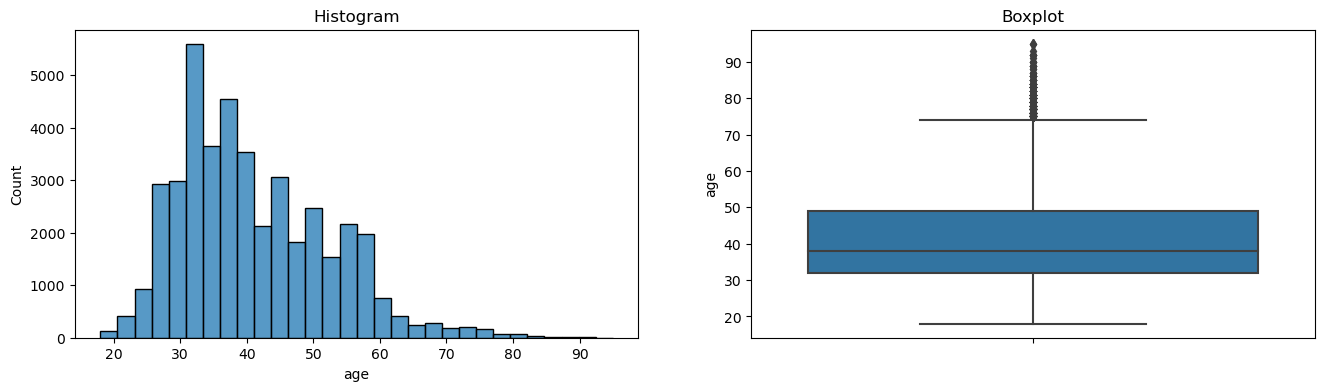


 Kolom age setelah dilakukan Capping


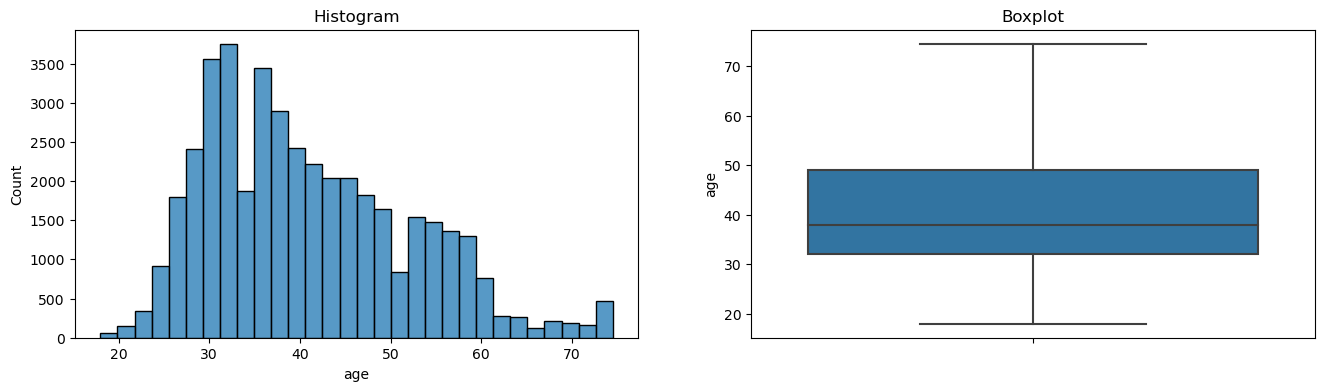

In [85]:
# Membuat fungsi untuk menampilkan histogram dan boxplot dari kolom 
def outliers_plots(df, variabel):    
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[variabel], bins=30)
    plt.title('Histogram')
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variabel])
    plt.title('Boxplot')
    plt.show()

# Melihat histogram dan boxplot kolom age(distribusi skewed)
print('Kolom age sebelum dilakukan capping')
outliers_plots(X_train_features, 'age')
print('\n Kolom age setelah dilakukan Capping')
outliers_plots(X_train_capped, 'age')

Berdasarkan histogram dan boxplot di atas, nilai dari kolom age berhasil dicapping sampai 70 saja dan outliers berhasil dihapus. Berikutnya saya akan melakukan scaling dan encoding

### Feature Scaling and Encoding

Pada bagian ini saya akan melakukan scaling terhadap kolom numerikal menggunakan standard scaler dan encoding terhadap kolom kategorikal menggunakan one hot dan ordinal encoding. Saya menggunakan min max scaler karena masih banyak terdapat kolom dengan distribusi skew. One hot encoding akan digunakan untuk mengubah kolom kategorikal tanpa urutan sedangkan ordinal encoding akan digunakan untuk mengubah kolom kategorikal dengan urutan

In [86]:
# Melakukan scaling menggunakan min max scaler terhadap kolom numerikal dan encoding menggunakan one hot dan ordinal encoder terhadap kolom kategorikal
scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown="ignore")
oe = OrdinalEncoder(categories=[['unknown','primary','secondary','tertiary']])
preprocess = ColumnTransformer([
        ('scaler', scaler, ['age','default','balance','housing','loan','day','campaign','pdays']),
        ('ohe', ohe, ['job','contact','month','poutcome']),
        ('oe', oe, ['education'])
    ]
)

Selanjutnya saya akan melakukan model definition

## 6. Model Definition

Pada bagian ini akan dilakukan pendefinisian model. Model yang akan digunakan yaitu Decision Tree, Random Forest, Support Vector Machine, K-Nearest Neighbors, dan AdaBoost. Kelima model ini saya gunakan karena cocok digunakan untuk melakukan klasifikasi. Hyperparameter akan dicari menggunakan cross validation dan random search. Hal ini ditujukan agar model memiliki performa yang maksimal. Metric yang akan saya gunakan yaitu f1 score. Metric ini saya gunakan karena metric ini cocok digunakan saat data yang digunakan adalah data imbalance 

In [87]:
pipe_dt = make_pipeline(preprocess, DecisionTreeClassifier(random_state=1))
pipe_rf = make_pipeline(preprocess, RandomForestClassifier(random_state=1))
pipe_svm = make_pipeline(preprocess, SVC(random_state=1))
pipe_knn = make_pipeline(preprocess, KNeighborsClassifier())
pipe_ada = make_pipeline(preprocess, AdaBoostClassifier(random_state=1))

## 7. Model Training

Pada bagian ini akan dilakukan training menggunakan model dan hyperparameter yang telah ditentukan

In [88]:
# Menentukan k dari cross validation
skfold = StratifiedKFold(n_splits=3)
# Menentukan nilai cross validation setiap model
cv_dt = cross_val_score(pipe_dt, X_train_capped, y_train_balanced, cv=skfold, scoring='f1', n_jobs=-1)
cv_rf = cross_val_score(pipe_rf, X_train_capped, y_train_balanced, cv=skfold, scoring='f1', n_jobs=-1)
cv_svm = cross_val_score(pipe_svm, X_train_capped, y_train_balanced, cv=skfold, scoring='f1', n_jobs=-1)
cv_knn = cross_val_score(pipe_knn, X_train_capped, y_train_balanced, cv=skfold, scoring='f1', n_jobs=-1)
cv_ada = cross_val_score(pipe_ada, X_train_capped, y_train_balanced, cv=skfold, scoring='f1', n_jobs=-1)

Berikutnya saya akan menentukan model terbaik berdasarkan nilai mean dari cross validation

In [89]:
# Menentukan model terbaik menggunakan looping berdasarkan nilai mean cross validation
name_model = []
cv_scores = 0
for cv, name in zip([cv_dt, cv_rf, cv_svm, cv_knn, cv_knn, cv_ada],
                    ['Decision Tree', 'Random Forest', 'SVM', 'K-Nearest Neighbor', 'AdaBoost']):
    print(name)
    print(f'F1-Score - ALL = cross validation: {cv}')
    print(f'F1-Score - Mean - cross validation: {cv.mean()}')
    print(f'F1-Score - Std - cross validation {cv.std()}')
    print(f'F1-Score - Range of tes set: {cv.mean()-cv.std()} - {cv.mean()+cv.std()}')
    print('-'*50)

    if cv.mean() > cv_scores:
        cv_scores = cv.mean()
        name_model = name 
    else:
        pass

print(f'Best Model: {name_model}')
print(f'Cross validation mean from best model: {cv_scores}')

Decision Tree
F1-Score - ALL = cross validation: [0.72058824 0.81790561 0.81216362]
F1-Score - Mean - cross validation: 0.7835524875937071
F1-Score - Std - cross validation 0.04458411842968949
F1-Score - Range of tes set: 0.7389683691640176 - 0.8281366060233966
--------------------------------------------------
Random Forest
F1-Score - ALL = cross validation: [0.75332187 0.88038867 0.88208883]
F1-Score - Mean - cross validation: 0.8385997895284563
F1-Score - Std - cross validation 0.06030458995775364
F1-Score - Range of tes set: 0.7782951995707026 - 0.8989043794862099
--------------------------------------------------
SVM
F1-Score - ALL = cross validation: [0.70979862 0.81410656 0.81410841]
F1-Score - Mean - cross validation: 0.7793378620901725
F1-Score - Std - cross validation 0.04917167150387382
F1-Score - Range of tes set: 0.7301661905862987 - 0.8285095335940463
--------------------------------------------------
K-Nearest Neighbor
F1-Score - ALL = cross validation: [0.72433077 0.817

Berdasarkan informasi di atas, ditemukan bahwa Random Forest merupakan model terbaik dari model lainnya pada kasus ini. Selanjutnya saya akan melakukan train data menggunakan Random Forest tanpa hyperparameter terlebih dahulu dilanjutkan dengan memakai hyperparameter yang ditentukan menggunakan random search. Keduanya akan dibandingkan performanya

In [90]:
# Melakukan data training menggunakan svm
pipe_rf.fit(X_train_capped, y_train_balanced)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'default', 'balance',
                                                   'housing', 'loan', 'day',
                                                   'campaign', 'pdays']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'contact', 'month',
                                                   'poutcome']),
                                                 ('oe',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                        

Berikutnya akan dilakukan prediksi terhadap data training dilanjutkan dengan data testing 

F1 Score - Train Set  :  0.999763638082632 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21155
           1       1.00      1.00      1.00     21155

    accuracy                           1.00     42310
   macro avg       1.00      1.00      1.00     42310
weighted avg       1.00      1.00      1.00     42310
 

Confusion Matrix      : 


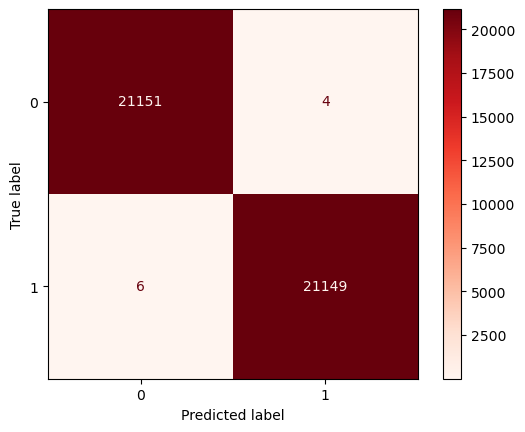

In [91]:
# Melakukan prediksi terhadap data training
y_pred_train = pipe_rf.predict(X_train_capped)
print('F1 Score - Train Set  : ', f1_score(y_train_balanced, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train_balanced, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_rf, X_train_capped, y_train_balanced, cmap='Reds'))

Berdasarkan informasi di atas, didapatkan nilai f1 score pada data training yaitu 0.99 atau 99%

F1 Score - Test Set   :  0.4141833270463975 

Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      7984
           1       0.34      0.52      0.41      1058

    accuracy                           0.83      9042
   macro avg       0.64      0.69      0.66      9042
weighted avg       0.86      0.83      0.84      9042
 

Confusion Matrix      : 


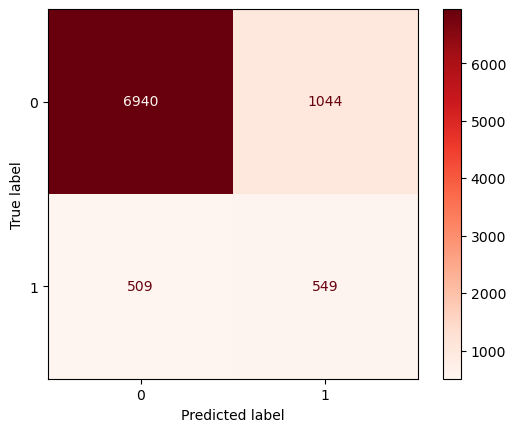

In [92]:
# Melakukan prediksi terhadap data testing
y_pred_test = pipe_rf.predict(X_test_capped)
print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test_capped, y_test, cmap='Reds'))

Berdasarkan informasi di atas, didapatkan nilai f1 score pada data testing yaitu 0.41 atau 41%. Saya akan menyimpan kedua nilai tersebut

In [93]:
# Membuat fungsi untuk menyimpan f1 score
all_reports = {}
def performance_report(all_reports, y_train_balanced, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
      'train - F1 score' : f1_score(y_train_balanced, y_pred_train),
      'test - F1 score' : f1_score(y_test, y_pred_test)
  }
  all_reports[name] = score_reports
  return all_reports
# Menyimpan nilai f1 score
all_reports = performance_report(all_reports, y_train_balanced, y_pred_train, y_test, y_pred_test, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
test - F1 score,0.414183
train - F1 score,0.999764


Berikutnya saya akan melakukan prediksi pada data training dan testing menggunakan Random Forest dengan hyperparameter. Saya akan mencari hyperparameter terbaik menggunakan random search

In [94]:
# Membuat nilai-nilai dari hyperparameter
n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 1000, 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_search_params = {'randomforestclassifier__n_estimators': n_estimators,
                        'randomforestclassifier__max_depth':max_depth,
                        'randomforestclassifier__min_samples_split':min_samples_split,
                        'randomforestclassifier__min_samples_leaf':min_samples_leaf}
random_search_params

{'randomforestclassifier__n_estimators': [200, 400, 600, 800, 1000],
 'randomforestclassifier__max_depth': [10, 257, 505, 752, 1000],
 'randomforestclassifier__min_samples_split': [2, 5, 10],
 'randomforestclassifier__min_samples_leaf': [1, 2, 4]}

In [95]:
rf_rand = RandomizedSearchCV(pipe_rf, param_distributions=random_search_params, cv=skfold, scoring='f1')
rf_rand.fit(X_train_capped, y_train_balanced)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                               ['age',
                                                                                'default',
                                                                                'balance',
                                                                                'housing',
                                                                                'loan',
                                                                                'day',
                                                                                'campaign',
                                     

In [96]:
# Melihat hyperparameter terbaik
best_params = rf_rand.best_params_
best_params

{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_depth': 505}

In [97]:
# Menyimpan model svm dengan hyperparameter terbaik pada variabel best_estimator
best_estimator = rf_rand.best_estimator_
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'default', 'balance',
                                                   'housing', 'loan', 'day',
                                                   'campaign', 'pdays']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'contact', 'month',
                                                   'poutcome']),
                                                 ('oe',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                        

Setelah ditemukan model Random Forest dengan hyperparameter terbaik. Saya akan melakukan prediksi terhadap data training dan testing

F1 Score - Train Set  :  0.93007293007293 

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     21155
           1       0.94      0.92      0.93     21155

    accuracy                           0.93     42310
   macro avg       0.93      0.93      0.93     42310
weighted avg       0.93      0.93      0.93     42310
 

Confusion Matrix      : 


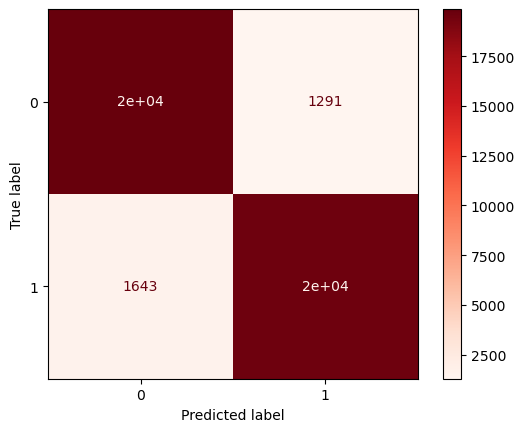

In [98]:
# Melakukan prediksi terhadap data training
y_pred_train = best_estimator.predict(X_train_capped)
print('F1 Score - Train Set  : ', f1_score(y_train_balanced, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train_balanced, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_train_capped, y_train_balanced, cmap='Reds'))

F1 Score - Test Set   :  0.4201556131900704 

Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      7984
           1       0.35      0.54      0.42      1058

    accuracy                           0.83      9042
   macro avg       0.64      0.70      0.66      9042
weighted avg       0.86      0.83      0.84      9042
 

Confusion Matrix      : 


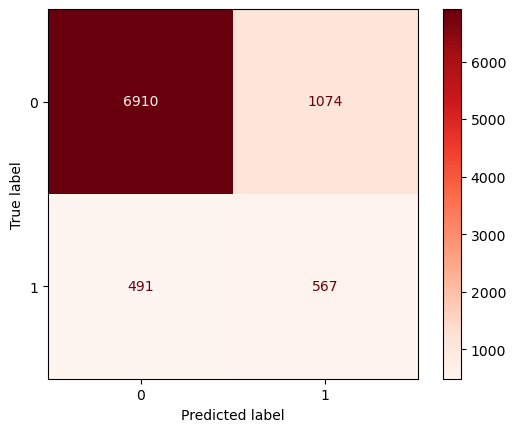

In [99]:
# Melakukan prediksi terhadap data testing
y_pred_test = best_estimator.predict(X_test_capped)
print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_test_capped, y_test, cmap='Reds'))

In [100]:
# Menyimpan dan menampilkan nilai f1 score 
all_reports = performance_report(all_reports, y_train_balanced, y_pred_train, y_test, y_pred_test, 'Random Search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Random Search
train - F1 score,0.999764,0.930073
test - F1 score,0.414183,0.420156


Selanjutnya saya akan melakukan model evaluation

## 8. Model Evaluation

Pada bagian ini akan dilakukan evaluasi terhadap model-model yang telah dibuat

In [101]:
# Menampilkan nilai f1 score 
all_reports = performance_report(all_reports, y_train_balanced, y_pred_train, y_test, y_pred_test, 'Random Search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Random Search
train - F1 score,0.999764,0.930073
test - F1 score,0.414183,0.420156


Berdasarkan informasi di atas, model dengan hyperparameter random search mempunyai performa yang sedikit lebih baik dibandingkan model tanpa hyperparameter. Disini saya menggunakan f1 score sebagai penilaian dikarenakan datasetnya yang imbalance dan dibutuhkan model yang dapat memprediksi respons dari klien berdasarkan informasi yang diberikan dengan tepat. Jika dilihat dari nilai train dan test, model tergolong overfit karena memiliki nilai train yang tinggi namun nilai test yang jauh lebih rendah. Berikutnya saya akan melakukan model saving terhadap model random search

## 9. Model Saving

Pada bagian ini akan dilakukan penyimpanan terhadap model yang telah dibuat beserta file-file lain yang berhubungan dengan model

In [102]:
# Menyimpan kolom/fitur yang akan digunakan untuk prediksi data inference
cols = X_test_capped.columns.to_list()
cols

['age',
 'job',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'campaign',
 'pdays',
 'poutcome']

In [106]:
# Menyimpan model dan file-file yang dibutuhkan
with open('list_cols.txt', 'w') as file_1:
  json.dump(cols, file_1)

with open('model_rf.pkl', 'wb') as file_2:
  pickle.dump(best_estimator, file_2)

Berikutnya saya akan melakukan model inference yang akan dilakukan pada file baru bernama inference.ipynb

## 11. Pengambilan Kesimpulan

Pada bagian ini akan dilakukan pengambilan kesimpulan berdasarkan hasil yang telah didapatkan

### Kesimpulan

F1 Score - Train Set  :  0.93007293007293 

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     21155
           1       0.94      0.92      0.93     21155

    accuracy                           0.93     42310
   macro avg       0.93      0.93      0.93     42310
weighted avg       0.93      0.93      0.93     42310
 

Confusion Matrix      : 


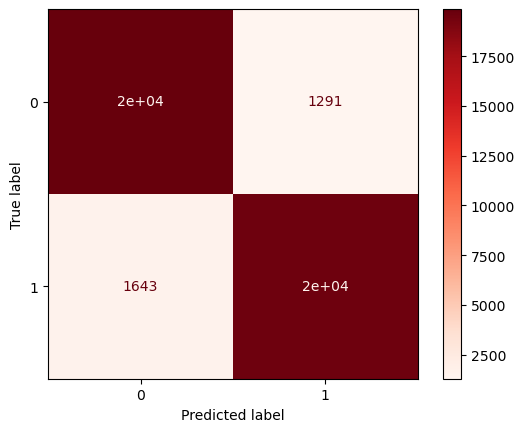

In [107]:
# Melihat performa model terhadap data training
y_pred_train = best_estimator.predict(X_train_capped)
print('F1 Score - Train Set  : ', f1_score(y_train_balanced, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train_balanced, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_train_capped, y_train_balanced, cmap='Reds'))

F1 Score - Test Set   :  0.4201556131900704 

Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      7984
           1       0.35      0.54      0.42      1058

    accuracy                           0.83      9042
   macro avg       0.64      0.70      0.66      9042
weighted avg       0.86      0.83      0.84      9042
 

Confusion Matrix      : 


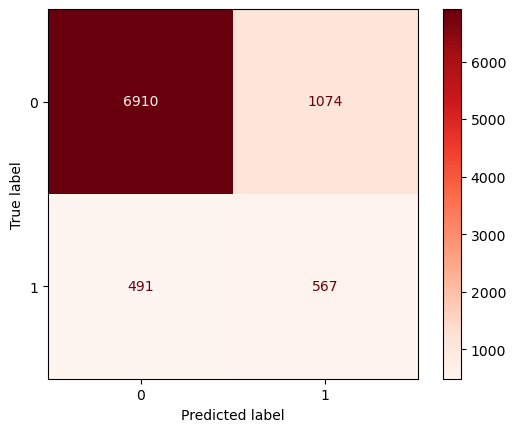

In [108]:
# Melihat performa model terhadap data testing
y_pred_test = best_estimator.predict(X_test_capped)
print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_estimator, X_test_capped, y_test, cmap='Reds'))

Berdasarkan model evaluation dan model inference yang telah dilakukan, model berhasil melakukan prediksi terhadap data baru/inference. Walaupun demikian, model tergolong overfit karena memiliki nilai test yang jauh lebih rendah dibandingkan nilai train yaitu 42% : 93%. Jika dilihat dari classification report dan confusion matrix data testing, model memiliki memiliki kelebihan dapat dengan baik memprediksi data dengan target 0/no dan memiliki kelemahan kesulitan memprediksi data dengan target 1/yes. Hal ini mungkin disebabkan karena data 1/yes sebagian besar merupakan data sintetik yang memiliki karakteristik yang sangat berbeda dengan data asli sehingga model hanya dapat melihat karakteristik data sintetik dan kesulitan melihat karakteristik data asli

### Saran

Disarankan dalam pembuatan model selanjutnya dapat melakukan handling terhadap data imbalance menggunakan metode balancing data yang lain. Dataset yang digunakan pada beberapa kolomnya masih terdapat nilai "unknown" sehingga dibutuhkan metode handling terhadap value "unknown". Model ini sudah cukup baik dalam memprediksi klien yang akan menolak penawaran sehingga pihak bank dapat lebih fokus dalam mencari klien dengan potensi menerima penawaran 

## Conceptual Problem

### 1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !

Metode bagging terinspirasi dari metode bootstrapping dengan menggabungkan Bootstrap dan AGGregating hingga dinamakan bagging. Cara kerja bagging adalah dengan melatih banyak model yang sama menggunakan data training yang berbeda-beda kemudian menggabungkan hasil prediksi dari tiap model

### 2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

Random forest menggunakan banyak model decision tree kemudian menggabungkan hasil prediksi setiap model sedangkan adaboost melakukan training model satu model kemudian kelemahan dari model ini akan diperbaiki oleh model selanjutnya 

### 3. Jelaskan apa yang dimaksud dengan Cross Validation !

Metode membagi dataset menjadi subset/fold untuk kemudian dilakukan pelatihan dan pengujian model berkali-kali berdasarkan jumlah subset/fold yang telah ditentukan 